# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


state vector dim = 4
n_actions = 2


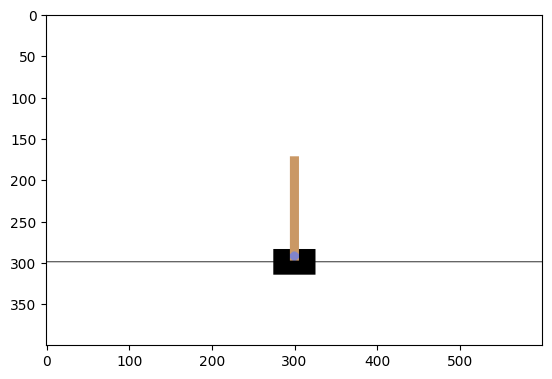

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [ ]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [ ]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1, -1)).flatten()

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p = probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.01998032  0.01295165  0.03922421  0.00261021]
 [-0.01972128  0.20748976  0.03927641 -0.27744353]
 [-0.01557149  0.01183012  0.03372755  0.02736386]
 [-0.01533488  0.20645258  0.03427482 -0.25448975]
 [-0.01120583  0.01085842  0.02918503  0.04880396]]
actions: [1, 0, 1, 0, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    reward_threshold = np.percentile(rewards_batch, q=percentile)
    elite_mask = rewards_batch >= reward_threshold

    elite_states = np.concatenate([state for state, is_elite in zip(states_batch, elite_mask) if is_elite])
    elite_actions = np.concatenate([action for action, is_elite in zip(actions_batch, elite_mask) if is_elite])

    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [ ]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 193.090, threshold=222.600


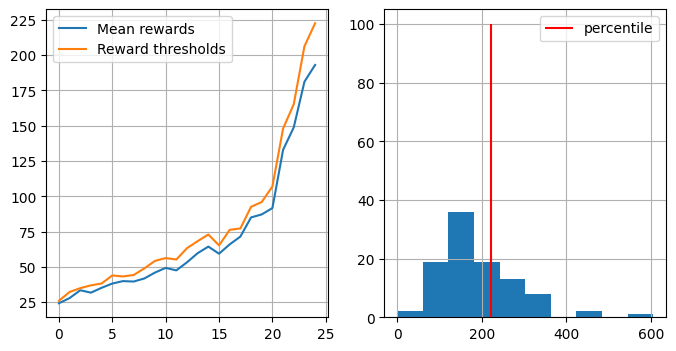

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)


    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break


# Results

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-1.mp4
Moviepy - Building video /content/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-2.mp4
Moviepy - Building video /content/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-3.mp4
Moviepy - Building video /content/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-4.mp4
Moviepy - Building video /content/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-5.mp4
Moviepy - Building video /content/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-6.mp4
Moviepy - Building video /content/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-7.mp4
Moviepy - Building video /content/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-8.mp4
Moviepy - Building video /content/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-9.mp4
Moviepy - Building video /content/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-10.mp4
Moviepy - Building video /content/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-11.mp4
Moviepy - Building video /content/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-12.mp4
Moviepy - Building video /content/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-13.mp4
Moviepy - Building video /content/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-14.mp4
Moviepy - Building video /content/videos/rl-video-episode-15.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-15.mp4
Moviepy - Building video /content/videos/rl-video-episode-16.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-16.mp4
Moviepy - Building video /content/videos/rl-video-episode-17.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-17.mp4
Moviepy - Building video /content/videos/rl-video-episode-18.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-18.mp4
Moviepy - Building video /content/videos/rl-video-episode-19.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-19.mp4
Moviepy - Building video /content/videos/rl-video-episode-20.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-20.mp4
Moviepy - Building video /content/videos/rl-video-episode-21.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-21.mp4
Moviepy - Building video /content/videos/rl-video-episode-22.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-22.mp4
Moviepy - Building video /content/videos/rl-video-episode-23.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-23.mp4
Moviepy - Building video /content/videos/rl-video-episode-24.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-24.mp4
Moviepy - Building video /content/videos/rl-video-episode-25.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-25.mp4
Moviepy - Building video /content/videos/rl-video-episode-26.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-26.mp4
Moviepy - Building video /content/videos/rl-video-episode-27.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-27.mp4
Moviepy - Building video /content/videos/rl-video-episode-28.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-28.mp4
Moviepy - Building video /content/videos/rl-video-episode-29.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-29.mp4
Moviepy - Building video /content/videos/rl-video-episode-30.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-30.mp4
Moviepy - Building video /content/videos/rl-video-episode-31.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-31.mp4
Moviepy - Building video /content/videos/rl-video-episode-32.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-32.mp4
Moviepy - Building video /content/videos/rl-video-episode-33.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-33.mp4
Moviepy - Building video /content/videos/rl-video-episode-34.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-34.mp4
Moviepy - Building video /content/videos/rl-video-episode-35.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-35.mp4
Moviepy - Building video /content/videos/rl-video-episode-36.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-36.mp4
Moviepy - Building video /content/videos/rl-video-episode-37.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-37.mp4
Moviepy - Building video /content/videos/rl-video-episode-38.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-38.mp4
Moviepy - Building video /content/videos/rl-video-episode-39.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-39.mp4
Moviepy - Building video /content/videos/rl-video-episode-40.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-40.mp4
Moviepy - Building video /content/videos/rl-video-episode-41.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-41.mp4
Moviepy - Building video /content/videos/rl-video-episode-42.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-42.mp4
Moviepy - Building video /content/videos/rl-video-episode-43.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-43.mp4
Moviepy - Building video /content/videos/rl-video-episode-44.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-44.mp4
Moviepy - Building video /content/videos/rl-video-episode-45.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-45.mp4
Moviepy - Building video /content/videos/rl-video-episode-46.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-46.mp4
Moviepy - Building video /content/videos/rl-video-episode-47.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-47.mp4
Moviepy - Building video /content/videos/rl-video-episode-48.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-48.mp4
Moviepy - Building video /content/videos/rl-video-episode-49.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-49.mp4
Moviepy - Building video /content/videos/rl-video-episode-50.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-50.mp4
Moviepy - Building video /content/videos/rl-video-episode-51.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-51.mp4
Moviepy - Building video /content/videos/rl-video-episode-52.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-52.mp4
Moviepy - Building video /content/videos/rl-video-episode-53.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-53.mp4
Moviepy - Building video /content/videos/rl-video-episode-54.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-54.mp4
Moviepy - Building video /content/videos/rl-video-episode-55.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-55.mp4
Moviepy - Building video /content/videos/rl-video-episode-56.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-56.mp4
Moviepy - Building video /content/videos/rl-video-episode-57.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-57.mp4
Moviepy - Building video /content/videos/rl-video-episode-58.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-58.mp4
Moviepy - Building video /content/videos/rl-video-episode-59.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-59.mp4
Moviepy - Building video /content/videos/rl-video-episode-60.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-60.mp4
Moviepy - Building video /content/videos/rl-video-episode-61.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-61.mp4
Moviepy - Building video /content/videos/rl-video-episode-62.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-62.mp4
Moviepy - Building video /content/videos/rl-video-episode-63.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-63.mp4
Moviepy - Building video /content/videos/rl-video-episode-64.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-64.mp4
Moviepy - Building video /content/videos/rl-video-episode-65.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-65.mp4
Moviepy - Building video /content/videos/rl-video-episode-66.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-66.mp4
Moviepy - Building video /content/videos/rl-video-episode-67.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-67.mp4
Moviepy - Building video /content/videos/rl-video-episode-68.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-68.mp4
Moviepy - Building video /content/videos/rl-video-episode-69.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-69.mp4
Moviepy - Building video /content/videos/rl-video-episode-70.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-70.mp4
Moviepy - Building video /content/videos/rl-video-episode-71.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-71.mp4
Moviepy - Building video /content/videos/rl-video-episode-72.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-72.mp4
Moviepy - Building video /content/videos/rl-video-episode-73.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-73.mp4
Moviepy - Building video /content/videos/rl-video-episode-74.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-74.mp4
Moviepy - Building video /content/videos/rl-video-episode-75.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-75.mp4
Moviepy - Building video /content/videos/rl-video-episode-76.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-76.mp4
Moviepy - Building video /content/videos/rl-video-episode-77.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-77.mp4
Moviepy - Building video /content/videos/rl-video-episode-78.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-78.mp4
Moviepy - Building video /content/videos/rl-video-episode-79.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-79.mp4
Moviepy - Building video /content/videos/rl-video-episode-80.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-80.mp4
Moviepy - Building video /content/videos/rl-video-episode-81.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-81.mp4
Moviepy - Building video /content/videos/rl-video-episode-82.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-82.mp4
Moviepy - Building video /content/videos/rl-video-episode-83.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-83.mp4
Moviepy - Building video /content/videos/rl-video-episode-84.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-84.mp4
Moviepy - Building video /content/videos/rl-video-episode-85.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-85.mp4
Moviepy - Building video /content/videos/rl-video-episode-86.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-86.mp4
Moviepy - Building video /content/videos/rl-video-episode-87.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-87.mp4
Moviepy - Building video /content/videos/rl-video-episode-88.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-88.mp4
Moviepy - Building video /content/videos/rl-video-episode-89.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-89.mp4
Moviepy - Building video /content/videos/rl-video-episode-90.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-90.mp4
Moviepy - Building video /content/videos/rl-video-episode-91.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-91.mp4
Moviepy - Building video /content/videos/rl-video-episode-92.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-92.mp4
Moviepy - Building video /content/videos/rl-video-episode-93.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-93.mp4
Moviepy - Building video /content/videos/rl-video-episode-94.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-94.mp4
Moviepy - Building video /content/videos/rl-video-episode-95.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-95.mp4
Moviepy - Building video /content/videos/rl-video-episode-96.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-96.mp4
Moviepy - Building video /content/videos/rl-video-episode-97.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-97.mp4
Moviepy - Building video /content/videos/rl-video-episode-98.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-98.mp4
Moviepy - Building video /content/videos/rl-video-episode-99.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-99.mp4


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


#**MY SOLUTION**

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()

n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(np.arange(n_actions), p = policy[s])

        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    return elite_states, elite_actions

In [ ]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy


def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1

    new_policy[new_policy.sum(axis = 1) == 0] = 1
    new_policy = new_policy / new_policy.sum(axis = 1, keepdims = True)

    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [ ]:
from tqdm import tqdm


def training_loop(n_sessions, percentile, n_epochs = 30):
    learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

    policy = initialize_policy(n_states, n_actions)

    log = []

    mean_rewards = []

    for i in tqdm(range(n_epochs)):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        mean_rewards.append(np.mean(rewards_batch))
    return mean_rewards

In [ ]:
import matplotlib.pyplot as plt

def visualize(mean_rewards, labels, title, reward_range=[-990, +10]):
    plt.figure(figsize=[10, 8])
    plt.subplot(1, 1, 1)
    plt.title(title, fontsize = 18)
    plt.ylabel("Reward", fontsize = 14)
    plt.xlabel("n_epochs", fontsize = 14)

    for reward, label in zip(mean_rewards, labels):
        plt.plot(reward, label=label)
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_sessions = 250
percentile = 50

rewards_all = []
labels = []
for n_sessions in [50, 100, 250, 500, 1000]:
    rewards = training_loop(n_sessions, percentile)
    rewards_all.append(rewards)
    labels.append(f"n_sessions = {n_sessions}")

100%|██████████| 30/30 [04:11<00:00,  8.39s/it]


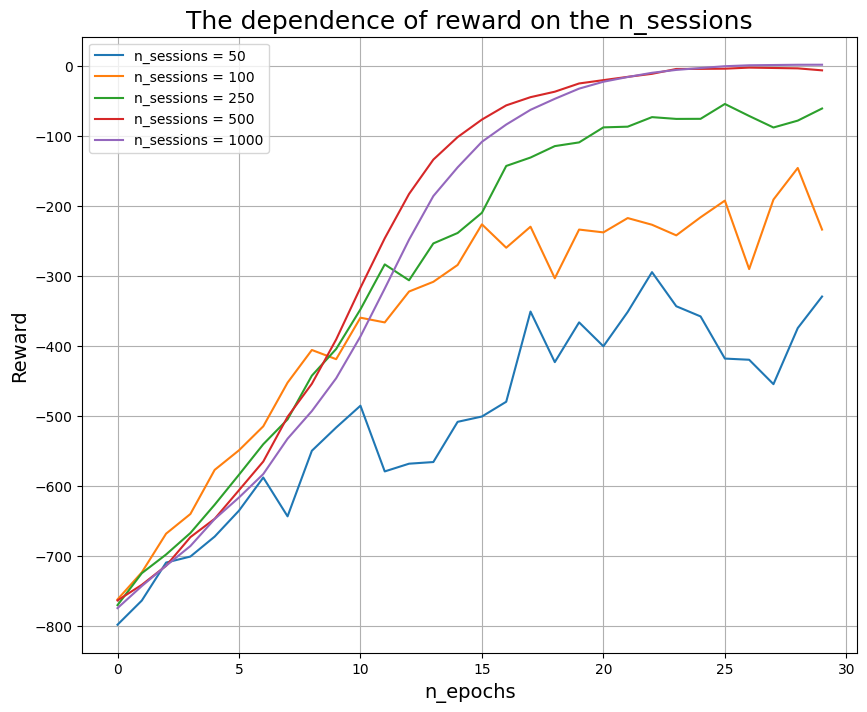

In [ ]:
visualize(rewards_all, labels, title = "The dependence of reward on the n_sessions")

In [ ]:
n_sessions = 250
percentile = 50

rewards_all = []
labels = []
for percentile in [30, 50, 75]:
    rewards = training_loop(n_sessions, percentile, n_epochs = 50)
    rewards_all.append(rewards)
    labels.append(f"percentile = {percentile}")

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


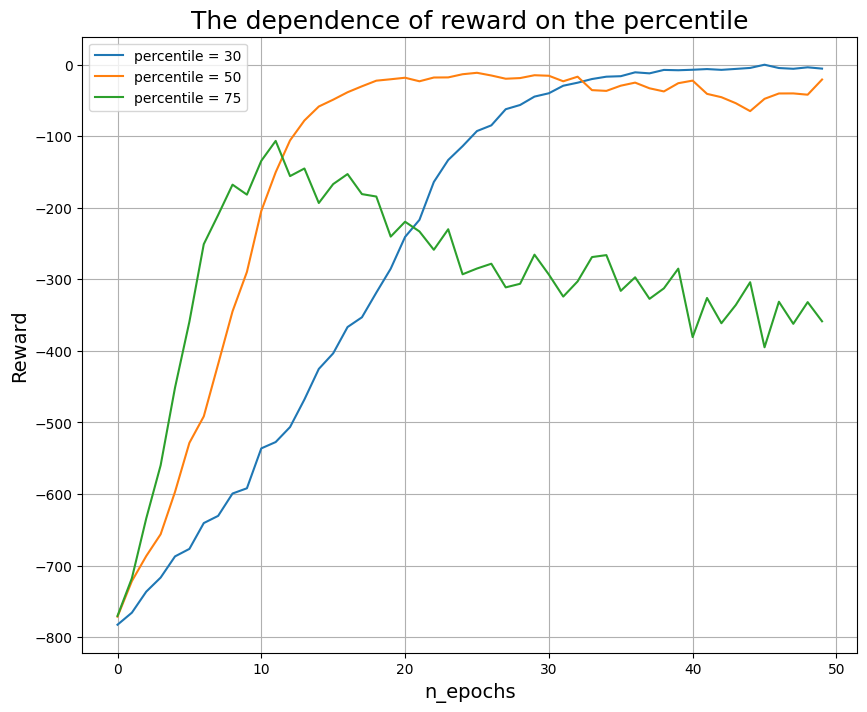

In [ ]:
visualize(rewards_all, labels, title = "The dependence of reward on the percentile")

A percentile that is too high does not converge, and a percentile that is too low converges slowly.

Experiments have shown that it is better to use more sessions and fewer percentiles, so let's use n_sessions = 1000 and percentile = 30

In [ ]:
n_sessions = 1000
percentile = 30

rewards = training_loop(n_sessions, percentile, n_epochs = 50)
label = f"n_sessions = {n_sessions}, percentile = {percentile}"

100%|██████████| 50/50 [05:33<00:00,  6.66s/it]


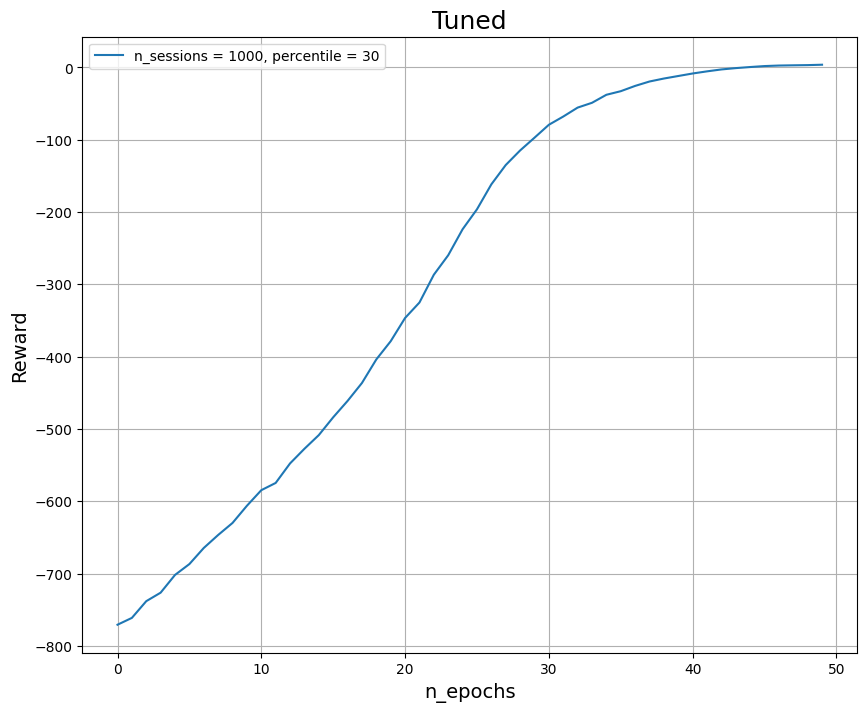

In [ ]:
visualize([rewards], [label], title = "Tuned")

In [ ]:
print(f"Last reward is {rewards[-1]}")

Last reward is 3.731


### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.